# Module 5 Final Project Submission

Please fill out:
* Student name: Fernando Aguilar Islas
* Student pace: Part-time
* Scheduled project review date/time: TBD
* Instructor name: Brandon Lewis
* Blog post URL: TBD


## 1. Introduction
For this project I will create a binary model classifier. I will be using a mushrooms dataset that classifies them as either edible or poisonous, making this a binary classification problem. The Audubon Society Field Guide to North American Mushrooms (1981) clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like "leaflets three, let it be''. This is opposite to what we know about berries with some rules like: "red and yellow kill a fellow, purple and blue good for you", so long as they do not grow in clusters (https://www.youtube.com/watch?time_continue=54&v=NWv5GD40nQA). Therefore, more attention needs to be paid when deciding whether or not a mushroom is edible or not. The data set contains 22 features, and all of them are categorical variables. They are the following:
* cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
* cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
* cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
* bruises: bruises=t,no=f
* odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
* gill-attachment: attached=a,descending=d,free=f,notched=n
* gill-spacing: close=c,crowded=w,distant=d
* gill-size: broad=b,narrow=n
* gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
* stalk-shape: enlarging=e,tapering=t
* stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
* stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
* stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
* stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
* stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
* veil-type: partial=p,universal=u
* veil-color: brown=n,orange=o,white=w,yellow=y
* ring-number: none=n,one=o,two=t
* ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
* spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
* population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
* habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

For more information about the dataset visit: https://www.kaggle.com/uciml/mushroom-classification

## 2 Framework
For this data set I will first perform exploration and data analysis, since all variables are categorical, I will mostly look for missing values and the content of each feature. Next, I will fit single model classifiers such as KNN, support vectors and decision trees. I will also tune the hyperparameters to obtain the best results. Further, I will look into ensembles such as Bagging, Random Forests,and XGBoost, to see if they outperform the single model classifier. Since ideally the classifier could be used as an app for people pacticing outdoor activities, I will prefer single model classifiers that require less memory capacity and not very computationally expensive. Let's start by importing the necessary libraries for the project.

### 2.1 Import Required Libraries

In [91]:
# EDA tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Single model classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

#Ensemble classifications models
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import xgboost as xgb

#Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,roc_curve, auc,f1_score

# Hyperparameter tunning and pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## 2.2 Helper Functions

In [115]:
def best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=10):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1

## 2. EDA and Pre-processing

In [2]:
#Load the file into a pandas data frame.
data = pd.read_csv("mushrooms.csv")
#Get structural information of the data set.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
class                       8124 non-null object
cap-shape                   8124 non-null object
cap-surface                 8124 non-null object
cap-color                   8124 non-null object
bruises                     8124 non-null object
odor                        8124 non-null object
gill-attachment             8124 non-null object
gill-spacing                8124 non-null object
gill-size                   8124 non-null object
gill-color                  8124 non-null object
stalk-shape                 8124 non-null object
stalk-root                  8124 non-null object
stalk-surface-above-ring    8124 non-null object
stalk-surface-below-ring    8124 non-null object
stalk-color-above-ring      8124 non-null object
stalk-color-below-ring      8124 non-null object
veil-type                   8124 non-null object
veil-color                  8124 non-null object
ring-number

The data set contains 23 columsn including the target column, leaving 22 features. All the columns are object datatypes since they are all categorical values. Let's visualize teh first 5 rows of the data.

In [3]:
#Visualize first 5 rows of data of the first 13 columns.
data.head().iloc[:,:13]

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring
0,p,x,s,n,t,p,f,c,n,k,e,e,s
1,e,x,s,y,t,a,f,c,b,k,e,c,s
2,e,b,s,w,t,l,f,c,b,n,e,c,s
3,p,x,y,w,t,p,f,c,n,n,e,e,s
4,e,x,s,g,f,n,f,w,b,k,t,e,s


In [4]:
#Visualize first 5 rows of data of the remaining columns.
data.head().iloc[:,13:]

,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,s,w,w,p,w,o,p,k,s,u
1,s,w,w,p,w,o,p,n,n,g
2,s,w,w,p,w,o,p,n,n,m
3,s,w,w,p,w,o,p,k,s,u
4,s,w,w,p,w,o,e,n,a,g


In [5]:
#Look for missing values.
data.isna().any()

class                       False
cap-shape                   False
cap-surface                 False
cap-color                   False
bruises                     False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-root                  False
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                   False
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
dtype: bool

Tha dataset does not have missing values.

e    4208
p    3916
Name: class, dtype: int64


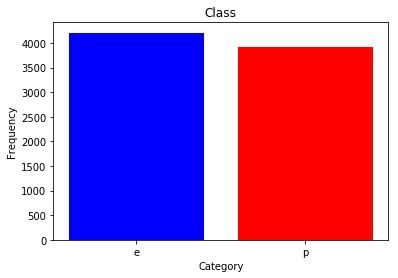

In [6]:
#Visualize distribution of the target variable in the dataset
print(data['class'].value_counts())
plt.bar(data['class'].value_counts().index, data['class'].value_counts(), color=['b','r'])
plt.title('Class')
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.show();

The dataset contains an almost equal amount of edible and poisonous samples. Now, I will one hot code the target variable as well as split the dataset into the target variable, 'class', and the features.

In [7]:
#Split the dataset into target and features dataframes.
data['class'] = data['class'].map({'p': 0, 'e': 1})
target = data['class']
features = data.drop('class', axis=1)

In [8]:
#Print the count of the different values for each of the features.
for col in features.columns:
    print(features[col].value_counts(),'\n')

x    3656
f    3152
k     828
b     452
s      32
c       4
Name: cap-shape, dtype: int64 

y    3244
s    2556
f    2320
g       4
Name: cap-surface, dtype: int64 

n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
r      16
u      16
Name: cap-color, dtype: int64 

f    4748
t    3376
Name: bruises, dtype: int64 

n    3528
f    2160
y     576
s     576
a     400
l     400
p     256
c     192
m      36
Name: odor, dtype: int64 

f    7914
a     210
Name: gill-attachment, dtype: int64 

c    6812
w    1312
Name: gill-spacing, dtype: int64 

b    5612
n    2512
Name: gill-size, dtype: int64 

b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: gill-color, dtype: int64 

t    4608
e    3516
Name: stalk-shape, dtype: int64 

b    3776
?    2480
e    1120
c     556
r     192
Name: stalk-root, dtype: int64 

s    5176
k    2372
f     552
y      24
Name: stalk-surface-above-ring, dtype: i

All of the features have at least 2 categories except for veil-type which is a constant for all of the samples with a p value, which means all of the sampes have  a partial veil type. Sine there is no varition in this category I will drop it since it does not provide any information to the models. After that I will proceed to one-hot-code the rest of the variables.

In [10]:
#Drop veil-type from the features.
features.drop('veil-type', axis=1, inplace=True)

#One-hot-code the features
ohc_feats = pd.get_dummies(features, drop_first=True)
print('New number of columns: ', ohc_feats.columns.shape[0])
ohc_feats.columns

New number of columns:  95


Index(['cap-shape_c', 'cap-shape_f', 'cap-shape_k', 'cap-shape_s',
       'cap-shape_x', 'cap-surface_g', 'cap-surface_s', 'cap-surface_y',
       'cap-color_c', 'cap-color_e', 'cap-color_g', 'cap-color_n',
       'cap-color_p', 'cap-color_r', 'cap-color_u', 'cap-color_w',
       'cap-color_y', 'bruises_t', 'odor_c', 'odor_f', 'odor_l', 'odor_m',
       'odor_n', 'odor_p', 'odor_s', 'odor_y', 'gill-attachment_f',
       'gill-spacing_w', 'gill-size_n', 'gill-color_e', 'gill-color_g',
       'gill-color_h', 'gill-color_k', 'gill-color_n', 'gill-color_o',
       'gill-color_p', 'gill-color_r', 'gill-color_u', 'gill-color_w',
       'gill-color_y', 'stalk-shape_t', 'stalk-root_b', 'stalk-root_c',
       'stalk-root_e', 'stalk-root_r', 'stalk-surface-above-ring_k',
       'stalk-surface-above-ring_s', 'stalk-surface-above-ring_y',
       'stalk-surface-below-ring_k', 'stalk-surface-below-ring_s',
       'stalk-surface-below-ring_y', 'stalk-color-above-ring_c',
       'stalk-color-above-rin

### 2.1 PCA Selection

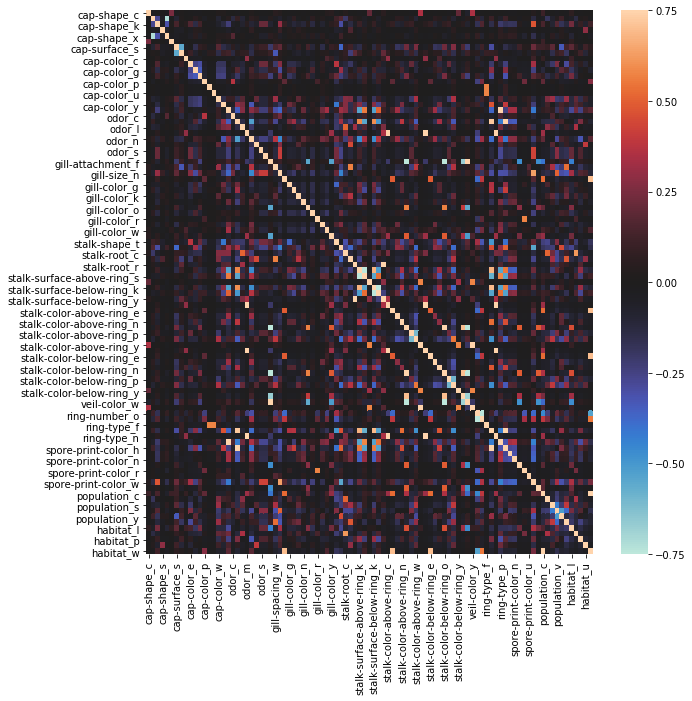

In [118]:
plt.figure(figsize=(10,10))
sns.heatmap(ohc_feats.corr(),vmin=-0.75,vmax=0.75,center=0);

In [104]:
pca = PCA(n_components=0.8)
pca_feats = pca.fit_transform(ohc_feats)
print(np.sum(pca.explained_variance_ratio_))
pca.n_components_

0.8109224422481134


20

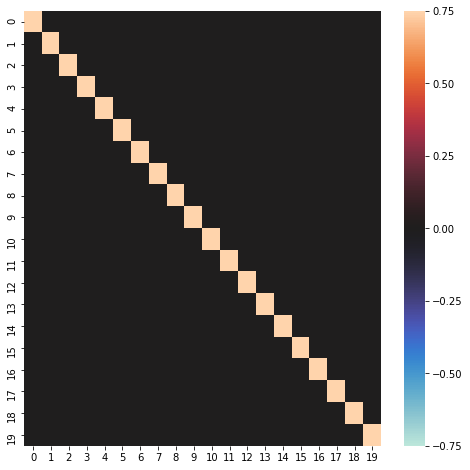

In [117]:
plt.figure(figsize=(8,8))
sns.heatmap(pd.DataFrame(pca_feats).corr(),vmin=-0.75,vmax=0.75,center=0);

In [111]:
X_train, X_test, y_train, y_test = train_test_split(pca_feats,target,test_size=0.3,random_state=617)

## 4. Single model classifiers

In [112]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
test_preds = clf.predict(X_test)
def print_metrics(labels, preds):
    #print("Precision Score: {}".format(precision_score(labels, preds)))
    #print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, test_preds)

Accuracy Score: 0.9979491386382281
F1 Score: 0.9980506822612086


In [116]:
find_best_k(X_train, y_train, X_test, y_test)

Best Value for k: 1
F1-Score: 0.9996107434799533


## 7. Bibliography and References
* Dataset: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.